In [1]:
import matplotlib.pyplot as plt

import numpy as np
from scipy.linalg import logm, expm,eig

from ncpol2sdpa import generate_variables, SdpRelaxation

from qutip import propagator, Qobj

from sympy import I, symbols, sympify, lambdify, Matrix, Float, Rational, pi, zeros, integrate, re
# from sympy import , eye, diag, Float, , , I, re, sin, , , 

from sympy.matrices import randMatrix, matrix2numpy

# Constructing quantum system

In [2]:
def get_random_matrix(n):
    """
    Generate random Hermitian matrix
    """
    H = randMatrix(4, percent=100) + I * randMatrix(4, percent=80)
    H = H.H + H
    
    return H / 200

Generate random quantum system with the hamiltonian
$\hat{H}(t) = \hat{H}_0 + u(t) \hat{V}$,
where $u(t)$ is a control field.

In [3]:
sys_params = dict(
    H0 = get_random_matrix(4),
    V = get_random_matrix(4),
    T = 1, # final time
)

# convert sympy matrix to qutip objects for subsequent propagation 
H0 = Qobj(matrix2numpy(sys_params['H0']))
V = Qobj(matrix2numpy(sys_params['V']))

Propagate to get the target unitary with some chose control

In [4]:
# the chosen control
u_original_str = 'cos(5 * t)'

# get target unitary
U_target = propagator([H0, [V, u_original_str]], sys_params['T'])

# covert the chosen control to the numpy function for plotting
t = symbols('t')
u_original = lambdify(t, sympify(u_original_str), 'numpy')

Extract the generator of dynamics by constructing the projectors and eigenenergies

$\hat{U} = \sum_{k=1}^N e^{i\phi_k} |k\rangle\langle k|$

In [5]:
vals, vects = eig(U_target)

# eigenenergies 
phi = np.angle(vals) # these are phi_k

# get projectors to eigenvectors
projectors = []

for psi in vects.T:
    psi = psi[:, np.newaxis]
    projectors.append(
        psi * psi.T.conj()
    )

rounding the projectors to avoid weird errors in sympy due to numerical noise

In [6]:
def round_matrix(G_exact):
    """
    Rounding matrix
    """
    for digit in range(10, 0, -1):
        G_exact_aroud = np.around(G_exact, digit)
        
        if np.alltrue(G_exact_aroud == G_exact_aroud.T.conj()):
            # sucess we got the hermitian matrix
            return G_exact_aroud

In [7]:
projectors = [Matrix(round_matrix(_)) for _ in projectors]
phi = [Float(_) for _ in np.around(phi, 10)]

# Construct the objective function

$\left\| e^{i\hat{G}} - e^{i\hat{H}} \right\|_F \leq \left\| \hat{G} - \hat{H} \right\|_F$
for Hermitian $\hat{G}$ and $\hat{H}$

In [8]:
def magnus_expansion(*, H0, V, u, T, **kwargs):
    """
    Symbolically construct the first two terms in the Magnus expansion
    """
    
    # symbols
    t1, t2 = symbols('t1, t2', real=True)
    
    # introduce alias 
    def h(t):
        return H0 + V * u(t)
    
    def Commutator(a, b):
        return a * b - b * a
    
    
    first_order = -integrate(h(t1), (t1, 0, T))
    
    second_order = -I * Rational(1, 2) * integrate(
        Commutator(integrate(h(t2), (t2, 0, t1)), h(t1)),
        (t1, 0, T)
    )
    
    return first_order + second_order

In [9]:
# time variable
t = symbols('t', real=True)

# the coefficients as varaibles to be minimize over
x = generate_variables('x', 4)

# define controls symbolically
u = lambdify(t, sum(c * t ** n_ for n_, c in enumerate(x)))

# !!!!! Jakub, the following variables are the new integer !!!!

In [10]:
n = generate_variables('n', len(phi))

Objective function

In [11]:
obj = (
    (
        magnus_expansion(u = u, **sys_params) 
        -
        sum(
            ((phi_ + 2 * pi * n_) * P for phi_, n_, P in zip(phi, n, projectors)),
            zeros(len(n))
        ) 
    ).norm() ** 2
).simplify()

Run optimization

In [12]:
# Until Jakub fixes this, we set all n to zero
obj = obj.subs(zip(n, [0] * len(n)))

In [13]:
sdp = SdpRelaxation(x)
sdp.get_relaxation(7, objective=re(obj))
sdp.solve(solver='mosek')

# extract the values of control
if sdp.status == 'optimal':
    opt_vals = [sdp[_] for _ in sdp.variables]
    
    # construct the control
    t = symbols('t')
    u_reconstructed = sum(c * t ** n_ for n_, c in enumerate(opt_vals))
    
    # Covert u_reconstructed to string for qutip below
    u_reconstructed_str = str(u_reconstructed)
    
    # u_reconstructed for plotting
    u_reconstructed = lambdify(t, u_reconstructed, 'numpy')

Get the value of the objective function

In [14]:
obj.subs(
    zip(sdp.variables, (sdp[_] for _ in sdp.variables))
).evalf()

0.00429227482851788 + 2.79352034620433e-18*I

Plot the recovered control via combative pop vs the original control

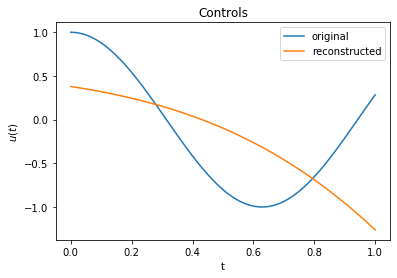

In [15]:
t = np.linspace(0, sys_params['T'], 100)

plt.title('Controls')
plt.plot(t, u_original(t), label='original')
plt.plot(t, u_reconstructed(t), label='reconstructed')
plt.ylabel('$u(t)$')
plt.xlabel('t')
plt.legend()
plt.show()

Get the norm difference between the target unitary and recovered unitary
$\left\| e^{i\hat{G}} - e^{i\hat{H}} \right\|_F$

In [16]:
Ug = propagator([H0, [V, u_reconstructed_str]], sys_params['T'])
(Ug - U_target).norm()

0.09715124654527188

In [17]:
U_target - Ug

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[-0.00448607-0.00449542j -0.0030052 -0.01106256j  0.01345558+0.00481428j
   0.0174818 -0.01246186j]
 [-0.00325641+0.00020788j -0.00126744-0.0021602j  -0.01250293+0.00401427j
   0.00360084+0.00577106j]
 [-0.01474973+0.02225972j  0.00108539+0.00251606j -0.00674364-0.00221097j
  -0.00289359-0.01691106j]
 [-0.03067385+0.00911621j -0.00744936+0.00727101j -0.0138401 -0.01180446j
   0.00206981+0.00275804j]]